<a href="https://colab.research.google.com/github/omarcevi/ML-Projects/blob/main/Maleria_detection_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import cv2
import albumentations as A

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Input, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.regularizers import L2

from sklearn.metrics import confusion_matrix, roc_curve

# Loading the dataset

In [ ]:
dataset, dataset_info = tfds.load('malaria',
                                with_info=True,
                                as_supervised=True,
                                shuffle_files=True,
                                split=['train'])

In [ ]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
IMAGE_SIZE = 224
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = dataset.skip(int((TRAIN_RATIO + VAL_RATIO)*DATASET_SIZE))

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# print(list(train_dataset.take(1).as_numpy_iterator()),
#       list(val_dataset.take(1).as_numpy_iterator()),
#       list(test_dataset.take(1).as_numpy_iterator()))

# Visualizing the dataset

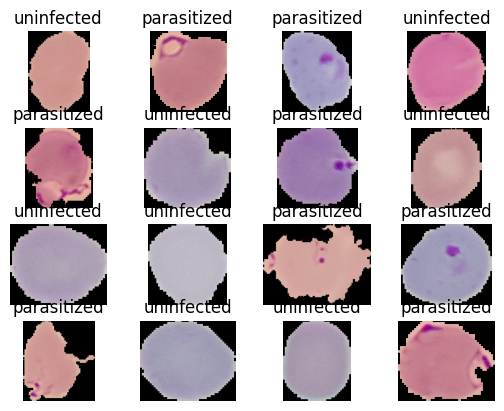

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

# Preprocessing

## Data Augmentation

In [ ]:
def visualizer(original, augmented):
    plt.subplot(1, 2, 1)
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.imshow(augmented)

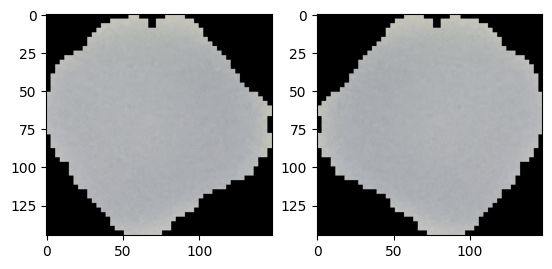

In [ ]:
original_image, label = next(iter(train_dataset))

augmented_image = tf.image.random_flip_left_right(
    original_image
)

visualizer(original_image, augmented_image)

In [ ]:
def resize_rescale(image, label):
    return tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))/255, label

In [ ]:
# tf.keras.layers resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/225)
])

In [ ]:
# tf.image augment

def augment(image, label):
    image, label = resize_rescale(image, label)

    image = tf.image.rot90(image)
    # image = tf.image.adjust_saturation(image, saturation_factor=0.3) makes the model worse
    image = tf.image.flip_left_right(image)

    return image, label

In [ ]:
# tf.keras.layer augment
augment_layers = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=(0.25, 0.2501),),
    tf.keras.layers.RandomFlip(mode='horizontal',),
])

def augment_layer(image, labels):
    return augment_layers(image, training=True), labels

In [ ]:
# for image, label in train_dataset.take(1):
#     print(image, label)

## Albumenations

In [ ]:
transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
        ]),
    A.RandomRotate90(),
    A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2,
                               contrast_limit=0.2,
                               brightness_by_max=True,
                               always_apply=False, p=0.5),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5)
])

# Data Loading

In [ ]:
BATCH_SIZE = 1

train_dataset = (train_dataset
                 .shuffle(buffer_size=8, reshuffle_each_iteration=True)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset
               .shuffle(buffer_size=8, reshuffle_each_iteration=True)
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE))
# test_dataset = test_dataset.map(resize_rescale)

# Model Definition

### Sequential API

In [ ]:
DROPOUT_RATE = 0.3
REGULARIZATION_RATE = 0.01

lenet_model_sequential = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),

    resize_rescale_layers,
    augment_layers,

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid',
           activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate=DROPOUT_RATE,),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
           activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate=DROPOUT_RATE,),
    Dense(10, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)      

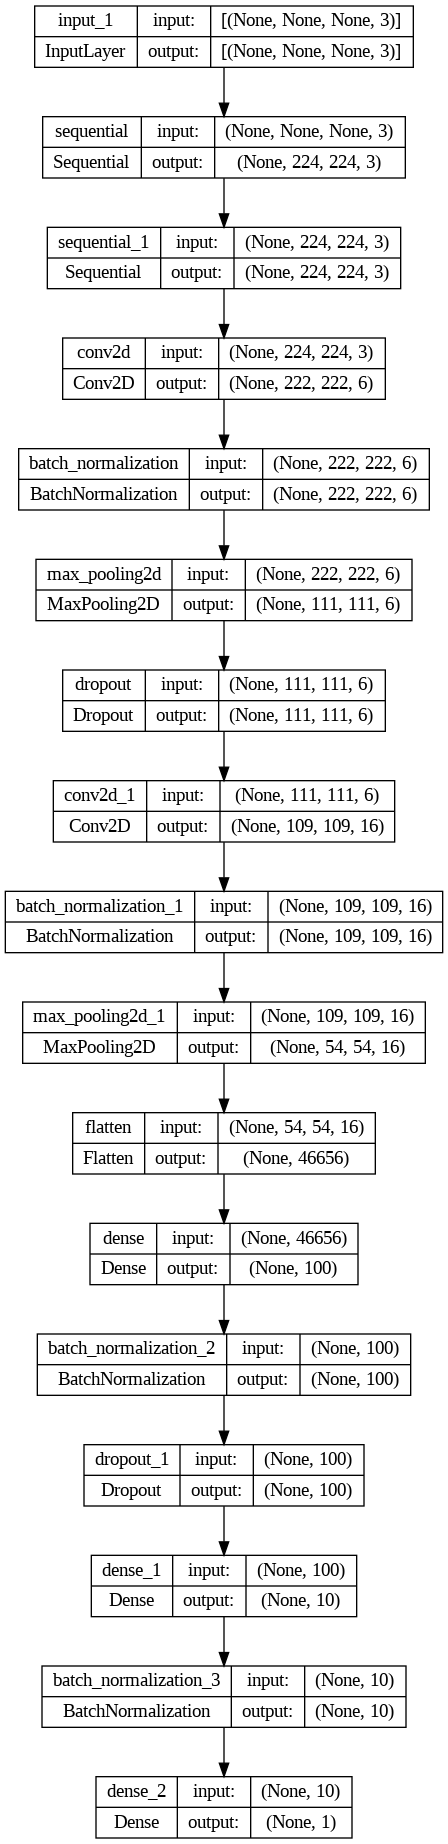

In [ ]:
lenet_model_sequential.summary()
tf.keras.utils.plot_model(lenet_model_sequential, show_shapes=True)

### Functional API

In [ ]:
func_input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3), name = "Input Image")

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
func_output = MaxPooling2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, func_output, name="Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_20 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_21 (Bat  (None, 109, 109, 16

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),])

In [ ]:
func_input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation='sigmoid')(x)

lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_10 (Sequential)  (None, 54, 54, 16)        1136      
                                                                 
 flatten_5 (Flatten)         (None, 46656)             0         
                                                                 
 dense_15 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_24 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 10)                1010      
                                                       

### Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
        super(FeatureExtractor, self).__init__()

        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPooling2D(pool_size=pool_size, strides=2*strides)

        self.conv_2 = Conv2D(filters=filters*2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPooling2D(pool_size=pool_size, strides=2*strides)

    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)

        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        return x

feature_sub_classed = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2,)

In [ ]:
class LenetModel(Model):
    def __init__(self,):
        super(LenetModel, self).__init__()

        self.feature_extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2,)

        self.flatten = Flatten()
        self.dense_1 = Dense(100, activation='relu')
        self.batch_1 = BatchNormalization()

        self.dense_2 = Dense(10, activation='relu')
        self.batch_2 = BatchNormalization()

        self.dense_3 = Dense(1, activation='sigmoid')

    def call(self, x, training):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)
        return x

lenet_sub_classed = LenetModel()
# lenet_sub_classed.build(input_shape=(None, 224, 224, 3))
lenet_sub_classed(tf.zeros([1,224, 224, 3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_6 (Flatten)         multiple                  0         
                                                                 
 dense_18 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_30 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_31 (Bat  multiple                 

### Defining a custom layar

In [ ]:
# From HOML book
class MyDense(Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name='kernel', shape=[batch_input_shape[-1], self.units],
            initializer='glorot_normal')
        self.bias = self.add_weight(
            name='bias', shape=[self.units], initializer='zeros')

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                'activation': tf.keras.activations.serialize(self.activation())}

class CustomDenseLayer(Layer):
    def __init__(self, output_units, activation):
        super(CustomDenseLayer, self).__init__()
        self.output_units = output_units
        self.activation = activation

    def build(self, input_features_shape):
        self.kernel = self.add_weight(shape=(input_features_shape[-1], self.output_units), initializer='random_normal', trainable=True)
        self.biases = self.add_weight(shape=(self.output_units,), initializer='random_normal', trainable=True)

    def call(self, input_features):
        if self.activation == 'relu':
            return tf.nn.relu(tf.matmul(input_features, self.kernel) + self.biases)
        elif self.activation == 'sigmoid':
            return tf.math.sigmoid(tf.matmul(input_features, self.kernel) + self.biases)
        else:
            return tf.matmul(input_features, self.kernel) + self.biases


In [ ]:
lenet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Flatten(),

    MyDense(100, activation='relu'),
    BatchNormalization(),
    MyDense(10, activation='relu'),
    BatchNormalization(),
    MyDense(1, activation='sigmoid'),
])

lenet_custom_model.summary()
# tf.keras.utils.plot_model(lenet_model, show_shapes=True)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_32 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_33 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                     

## Callbacks

In [ ]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print(f"\n For epoch number {epoch+1} the model has a loss of {logs['loss']}")

    # def on_batch_end(self, batch, logs):
    #     print(f"\n For batch number {batch+1} the model has a loss of {logs['loss']}")


# Early stopping
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

# Learning Rate Scheduler
def schedule(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(
    schedule=schedule,
    verbose=1
)

# Model Checkpointing
checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints/', monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None,
)


# Model Training

In [ ]:
from os import name
# Defining the used model
MODEL = lenet_model_sequential

# METRICS = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
#             BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

METRICS = [BinaryAccuracy(name='accuracy')]

In [ ]:
MODEL.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS,
)

In [ ]:
lenet_history = MODEL.fit(
                    train_dataset,
                    validation_data=val_dataset,
                    epochs=50,
                    verbose=1,
                    callbacks=[LossCallback(), lr_scheduler, checkpoint_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/50
22046/22046 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.4974
 For epoch number 1 the model has a loss of 0.6991491913795471


22046/22046 [==============================] - 231s 10ms/step - loss: 0.6991 - accuracy: 0.4974 - val_loss: 0.6977 - val_accuracy: 0.4813 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/50
22046/22046 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.5013
 For epoch number 2 the model has a loss of 0.6983773112297058


22046/22046 [==============================] - 220s 10ms/step - loss: 0.6984 - accuracy: 0.5013 - val_loss: 0.7004 - val_accuracy: 0.4817 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/50
22046/22046 [==============================] - ETA: 0s - loss: 0.6986 - accuracy: 0.4987
 For epoch number 3 the model has a loss of 0.6985639333724976


22046/22046 [==============================] - 215s 10ms/step - loss: 0.6986 - accuracy: 0.4987 - val_loss: 0.6979 - val_accuracy: 0.4813 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009048373438417912.
Epoch 4/50
22046/22046 [==============================] - ETA: 0s - loss: 0.6978 - accuracy: 0.4971
 For epoch number 4 the model has a loss of 0.6978427171707153


22046/22046 [==============================] - 212s 10ms/step - loss: 0.6978 - accuracy: 0.4971 - val_loss: 0.6988 - val_accuracy: 0.4813 - lr: 0.0090

Epoch 5: LearningRateScheduler setting learning rate to 0.008187306113541126.
Epoch 5/50
22045/22046 [============================>.] - ETA: 0s - loss: 0.6972 - accuracy: 0.4963
 For epoch number 5 the model has a loss of 0.6972026824951172


22046/22046 [==============================] - 214s 10ms/step - loss: 0.6972 - accuracy: 0.4963 - val_loss: 0.6966 - val_accuracy: 0.4817 - lr: 0.0082

Epoch 6: LearningRateScheduler setting learning rate to 0.0074081807397305965.
Epoch 6/50
22041/22046 [============================>.] - ETA: 0s - loss: 0.6965 - accuracy: 0.5002
 For epoch number 6 the model has a loss of 0.6964931488037109


22046/22046 [==============================] - 214s 10ms/step - loss: 0.6965 - accuracy: 0.5002 - val_loss: 0.6976 - val_accuracy: 0.4813 - lr: 0.0074

Epoch 7: LearningRateScheduler setting learning rate to 0.00670319888740778.
Epoch 7/50
22040/22046 [============================>.] - ETA: 0s - loss: 0.6960 - accuracy: 0.4954
 For epoch number 7 the model has a loss of 0.6960225701332092


22046/22046 [==============================] - 213s 10ms/step - loss: 0.6960 - accuracy: 0.4953 - val_loss: 0.6959 - val_accuracy: 0.4820 - lr: 0.0067

Epoch 8: LearningRateScheduler setting learning rate to 0.006065304856747389.
Epoch 8/50
22042/22046 [============================>.] - ETA: 0s - loss: 0.6956 - accuracy: 0.4969
 For epoch number 8 the model has a loss of 0.6955746412277222


22046/22046 [==============================] - 213s 10ms/step - loss: 0.6956 - accuracy: 0.4969 - val_loss: 0.6965 - val_accuracy: 0.4817 - lr: 0.0061

Epoch 9: LearningRateScheduler setting learning rate to 0.005488114431500435.
Epoch 9/50
22045/22046 [============================>.] - ETA: 0s - loss: 0.6954 - accuracy: 0.4983
 For epoch number 9 the model has a loss of 0.6953630447387695


22046/22046 [==============================] - 217s 10ms/step - loss: 0.6954 - accuracy: 0.4982 - val_loss: 0.6950 - val_accuracy: 0.4817 - lr: 0.0055

Epoch 10: LearningRateScheduler setting learning rate to 0.004965851083397865.
Epoch 10/50
22044/22046 [============================>.] - ETA: 0s - loss: 0.6951 - accuracy: 0.4959
 For epoch number 10 the model has a loss of 0.6951195001602173


22046/22046 [==============================] - 213s 10ms/step - loss: 0.6951 - accuracy: 0.4959 - val_loss: 0.6954 - val_accuracy: 0.4817 - lr: 0.0050

Epoch 11: LearningRateScheduler setting learning rate to 0.004493287764489651.
Epoch 11/50
22046/22046 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.4956
 For epoch number 11 the model has a loss of 0.6947962045669556


22046/22046 [==============================] - 213s 10ms/step - loss: 0.6948 - accuracy: 0.4956 - val_loss: 0.6956 - val_accuracy: 0.4817 - lr: 0.0045

Epoch 12: LearningRateScheduler setting learning rate to 0.0040656947530806065.
Epoch 12/50
22040/22046 [============================>.] - ETA: 0s - loss: 0.6945 - accuracy: 0.4983
 For epoch number 12 the model has a loss of 0.6944640874862671


22046/22046 [==============================] - 214s 10ms/step - loss: 0.6945 - accuracy: 0.4983 - val_loss: 0.6968 - val_accuracy: 0.4813 - lr: 0.0041

Epoch 13: LearningRateScheduler setting learning rate to 0.0036787926219403744.
Epoch 13/50
22042/22046 [============================>.] - ETA: 0s - loss: 0.6944 - accuracy: 0.4961
 For epoch number 13 the model has a loss of 0.6943829655647278


22046/22046 [==============================] - 212s 10ms/step - loss: 0.6944 - accuracy: 0.4960 - val_loss: 0.6955 - val_accuracy: 0.4817 - lr: 0.0037

Epoch 14: LearningRateScheduler setting learning rate to 0.0033287089318037033.
Epoch 14/50
22043/22046 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.4987
 For epoch number 14 the model has a loss of 0.694189190864563


22046/22046 [==============================] - 212s 10ms/step - loss: 0.6942 - accuracy: 0.4987 - val_loss: 0.6950 - val_accuracy: 0.4817 - lr: 0.0033

Epoch 15: LearningRateScheduler setting learning rate to 0.0030119402799755335.
Epoch 15/50
22043/22046 [============================>.] - ETA: 0s - loss: 0.6941 - accuracy: 0.4944
 For epoch number 15 the model has a loss of 0.6940765976905823


22046/22046 [==============================] - 212s 10ms/step - loss: 0.6941 - accuracy: 0.4944 - val_loss: 0.6947 - val_accuracy: 0.4817 - lr: 0.0030

Epoch 16: LearningRateScheduler setting learning rate to 0.00272531621158123.
Epoch 16/50
22040/22046 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.4976
 For epoch number 16 the model has a loss of 0.6939764022827148


22046/22046 [==============================] - 214s 10ms/step - loss: 0.6940 - accuracy: 0.4976 - val_loss: 0.6953 - val_accuracy: 0.4820 - lr: 0.0027

Epoch 17: LearningRateScheduler setting learning rate to 0.002465968020260334.
Epoch 17/50
22046/22046 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.4950
 For epoch number 17 the model has a loss of 0.6940097212791443


22046/22046 [==============================] - 216s 10ms/step - loss: 0.6940 - accuracy: 0.4950 - val_loss: 0.6948 - val_accuracy: 0.4806 - lr: 0.0025

Epoch 18: LearningRateScheduler setting learning rate to 0.0022313001099973917.
Epoch 18/50
22040/22046 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.4941
 For epoch number 18 the model has a loss of 0.693791925907135


22046/22046 [==============================] - 214s 10ms/step - loss: 0.6938 - accuracy: 0.4941 - val_loss: 0.6949 - val_accuracy: 0.4813 - lr: 0.0022

Epoch 19: LearningRateScheduler setting learning rate to 0.002018963685259223.
Epoch 19/50
22043/22046 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.4947
 For epoch number 19 the model has a loss of 0.693808376789093


22046/22046 [==============================] - 214s 10ms/step - loss: 0.6938 - accuracy: 0.4947 - val_loss: 0.6950 - val_accuracy: 0.4817 - lr: 0.0020

Epoch 20: LearningRateScheduler setting learning rate to 0.0018268338171765208.
Epoch 20/50
22042/22046 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4942
 For epoch number 20 the model has a loss of 0.6937042474746704


22046/22046 [==============================] - 216s 10ms/step - loss: 0.6937 - accuracy: 0.4942 - val_loss: 0.6943 - val_accuracy: 0.4813 - lr: 0.0018

Epoch 21: LearningRateScheduler setting learning rate to 0.001652987557463348.
Epoch 21/50
22044/22046 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4952
 For epoch number 21 the model has a loss of 0.6936708092689514


22046/22046 [==============================] - 218s 10ms/step - loss: 0.6937 - accuracy: 0.4951 - val_loss: 0.6945 - val_accuracy: 0.4813 - lr: 0.0017


KeyboardInterrupt: ignored

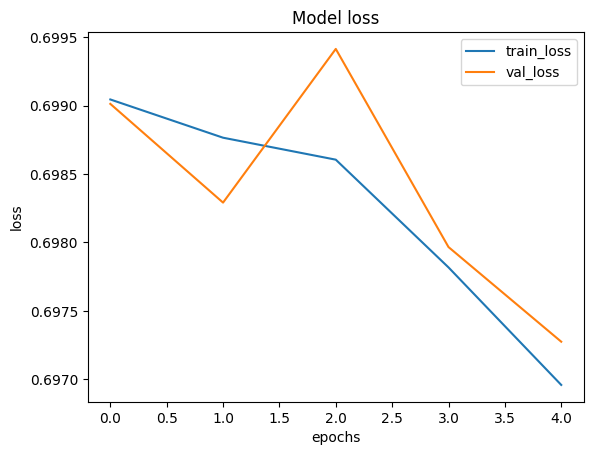

In [ ]:
plt.plot(lenet_history.history['loss'])
plt.plot(lenet_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

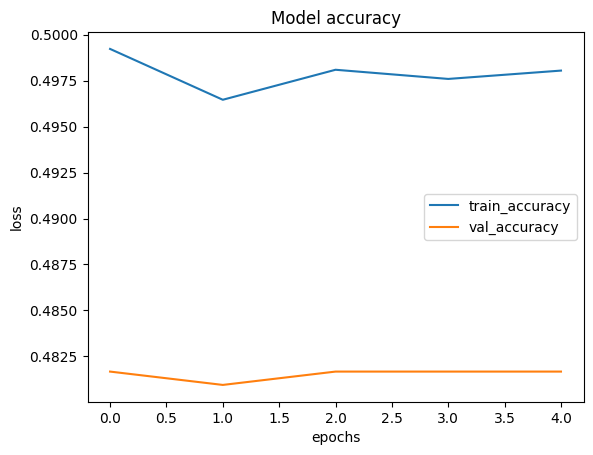

In [ ]:
plt.plot(lenet_history.history['accuracy'])
plt.plot(lenet_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
MODEL.evaluate(test_dataset)

2756/2756 [==============================] - 30s 7ms/step - loss: 0.4736 - tp: 1323.0000 - fp: 127.0000 - tn: 1265.0000 - fn: 41.0000 - accuracy: 0.9390 - precision: 0.9124 - recall: 0.9699 - auc: 0.9704


[0.47361087799072266,
 1323.0,
 127.0,
 1265.0,
 41.0,
 0.9390420913696289,
 0.9124137759208679,
 0.9699413776397705,
 0.9703941345214844]

# Visualizing Confusion Matrix

In [ ]:
input = []
labels = []
for X, y in test_dataset.as_numpy_iterator():
    input.append(X)
    labels.append(y)

labels = np.array([i[0] for i in labels])
print(labels)

[1 0 0 ... 1 0 0]


In [ ]:
print(np.array(input).shape)
print(np.array(input)[:, 0, ...].shape)

(2756, 1, 224, 224, 3)
(2756, 224, 224, 3)


In [ ]:
predicted = lenet_model.predict(np.array(input)[:, 0, ...])
print(predicted[:,0])

87/87 [==============================] - 1s 15ms/step
[9.2455608e-01 1.1878201e-03 9.4401219e-04 ... 9.9630898e-01 3.2102740e-03
 8.1374071e-04]


[[1268  129]
 [  41 1318]]


Text(70.72222222222221, 0.5, 'Actual')

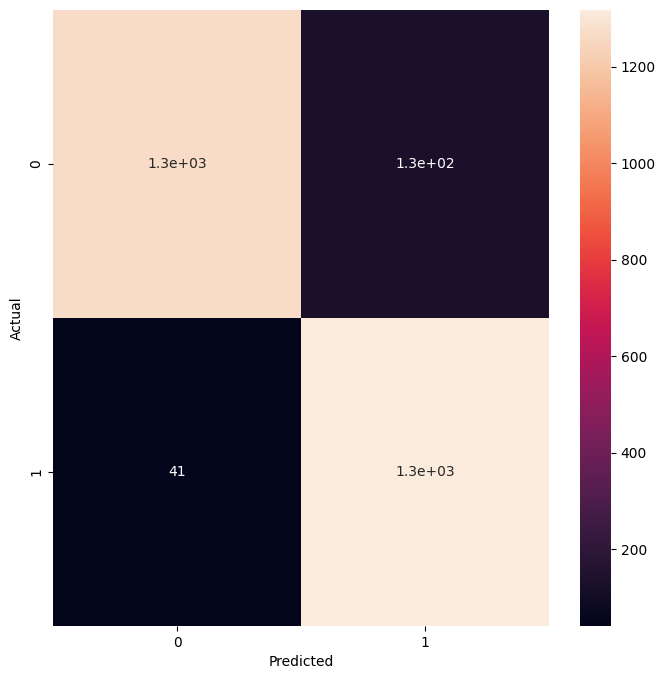

In [ ]:
THRESHOLD = 0.5

cm = confusion_matrix(labels, predicted > THRESHOLD)
print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True,)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# tp: 1323.0000 - fp: 127.0000 - tn: 1265.0000 - fn: 41.0000

# ROC Plot

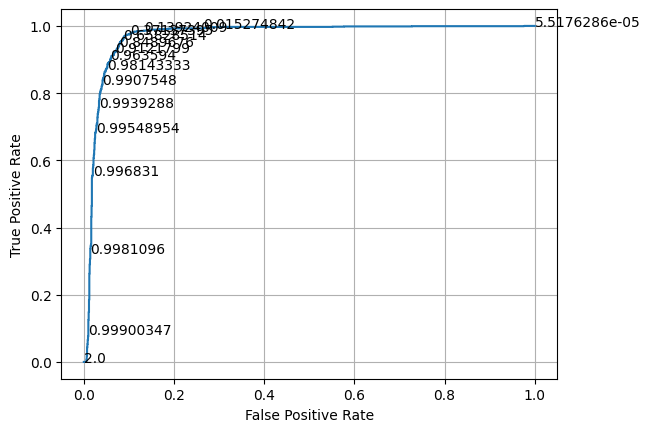

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])
plt.show()

# Model Prediction

In [ ]:
def infected_or_not(x):
    if(x<0.5):
        return str('P')
    else:
        return str('N')

infected_or_not(MODEL.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 18s 18s/step


'N'

1/1 [==============================] - 0s 33ms/step


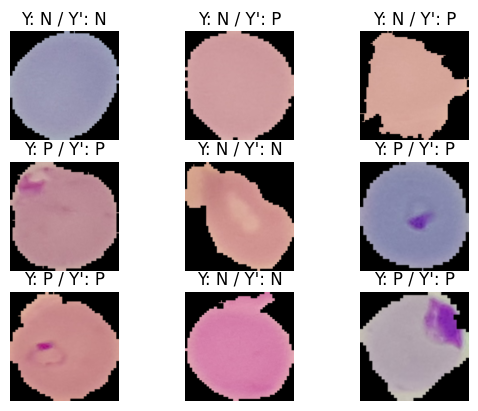

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    plt.title(f"Y: {infected_or_not(label.numpy()[0])} / Y': {infected_or_not(MODEL.predict(image)[0][0])}")

    plt.axis('off')

# Loading and Saving

In [ ]:
MODEL.save("lenet")

lenet_loaded_model = tf.keras.models.load_model("lenet")
lenet_loaded_model.summary()


MODEL.save("lenet.hdf5")


lenet_loaded_model = tf.keras.models.load_model("lenet.hdf5")
lenet_loaded_model.summary()


MODEL.save_weights("weights/lenet_weights")


lenet_weights_model = MODEL.load_weights("weights/lenet_weights")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

# Saving / Loading : GDrive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cp -r /content/lenet/ /content/drive/MyDrive/colab_files/TF_Models/

In [ ]:
!cp -r /content/drive/MyDrive/colab_files/TF_Models/ /content/lenet_colab/